# Generative Adversarial Learning for Intelligent 5G Interference Mitigation

In this notebook, we implement a generative adversarial network (GAN) for use in 5G wireless interference mitigation.

In [144]:
# %matplotlib inline

from __future__ import annotations
from cycler import cycler
import json
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import shutil
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable, Literal

sns.set() # Use seaborn themes.

In [145]:
import os
os.environ.get('LD_LIBRARY_PATH')

'/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64:/lib/:/home/acd1797/.conda/envs/tf-gpu/lib/'

In [146]:
tf.__version__

'2.11.0'

In [147]:
tf.test.is_built_with_cuda()

True

In [148]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [149]:
# Here define some root paths for saving content.
roots = dict(
    dataset = Path('./dataset/'),
    images = Path('./images/'),
    tuning = Path('./tuning/'),
)
for k,r in roots.items(): # Create directories if they do not already exist.
    if not r.exists():
        r.mkdir(exist_ok=True)

## Training

This section contains helper functions to train and evaluate models.

In [150]:
def load_metrics(metrics_path: str):
    """Load model metrics from file."""
    with open(metrics_path, 'r') as f:
        return json.load(f)

def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)

def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path,
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model

In [151]:
def train_evaluate_model(
    model,
    datagen_train: tf.data.Dataset,
    datagen_val: tf.data.Dataset,
    datagen_test: tf.data.Dataset,
    epochs: int,
    checkpoint_path: Path,
    history_path: Path = None,
    metrics_path: Path = None,
    callbacks: list = [],
    ) -> tuple[keras.models.Model, pd.DataFrame, dict]:
    """Trains and evaluates a given model on the given datasets.
    Args:
        model (_type_): The model to train and evaluation.
        datagen_train (tf.data.Dataset): Training dataset.
        datagen_val (tf.data.Dataset): Validation dataset.
        datagen_test (tf.data.Dataset): Testing dataset.
        epochs (int): Number of training epochs.
        checkpoint_path (Path): Path to checkpoint file
        history_path (Path, optional): Path to history CSV file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"history.csv"`. Defaults to None.
        metrics_path (Path, optional): Path to metrics JSON file. If None is provided, then the file will be located at the same path as the checkpoint file with name `"metrics.json"`. Defaults to None.
        callbacks (list, optional): Additional callbacks during training. Defaults to an empty list.
    Returns:
        tuple[keras.models.Model, pd.DataFrame, dict: Tuple of trained model, history dataframe, and metrics dictionary.
    """

    # Ensure checkpoint root directory has been created.
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    if history_path is None:
        history_path = checkpoint_path.parent/'history.csv'
    if metrics_path is None:
        metrics_path = checkpoint_path.parent/'metrics.json'

    # List of callbacks during training.
    callbacks = callbacks.copy() # Create a copy so that the original is not modified.
    callbacks.extend([
        # Save model checkpoint after every epoch.
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            mode='auto',
            save_best_only=True,
            # verbose=1,
        ),
        # Log training history to CSV file.
        keras.callbacks.CSVLogger(
            filename=history_path,
            append=False,
        ),
    ])

    # Train the model.
    history = model.fit(datagen_train,
        validation_data=datagen_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Evaluate the newly trained model.
    test_metrics = model.evaluate(datagen_test)

    # Create dictionary of metrics to return and preserve in file.
    metrics = {}
    for i, (key, val) in enumerate(history.history.items()):
        metrics[key] = val[-1]
        if not key.startswith('val_'):
            metrics[f"test_{key}"] = test_metrics[i]

    # Dump metrics to JSON file.
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    return model, pd.DataFrame(history.history), metrics

In [152]:
def hypertune(
    hparams: dict,
    build_model_func: Callable[[dict], keras.Model], # this function must compile the model too.
    dataset_loader_func: Callable[[int], tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]],
    epochs: int,
    batch_size: int,
    tuning_root: str|Path,
    strategy: tf.distribute.Strategy = tf.distribute.get_strategy(),
    callbacks: list = [],
    override_load: bool = False,
    ):

    # Create the tuning directory for this model if it does not already exist.
    tuning_root.mkdir(parents=True, exist_ok=True)

    # Pre-load dataset for faster training.
    with strategy.scope():
        dataset_train, dataset_val, dataset_test = dataset_loader_func(batch_size)

    # Build parameter grid.
    grid = ParameterGrid(hparams)
    print(f"Evaluating {len(grid)} hyperparameter combinations")

    # Validate any previous parameter grid runs to ensure parameters were the same.
    # If same, then do nothing. If different, then remove all old contents.
    parameter_grid_path = tuning_root/'parameter_grid.json'
    if parameter_grid_path.exists():
        with open(parameter_grid_path, 'r') as f:
            old_grid = json.load(f)

        # New grid is different, so overwrite everything.
        new_grid = list(grid)
        if old_grid != new_grid:

            # Recreate tuning directory.
            shutil.rmtree(tuning_root)
            tuning_root.mkdir(parents=True, exist_ok=True)

    # Update parameter grid file.
    with open(parameter_grid_path, 'w') as f:
        json.dump(list(grid), f, default=lambda o: '<not serializable>')

    # Iterate over parameter grid.
    # Trains one model per parameter set.
    df_results: list[dict] = [] # Result dictionaries for each model (will be converted to a DataFrame object later).
    histories: list = [] # History lists for each model.
    for i, p in enumerate(grid):

        # Build current model name string.
        cur_model_name = f"model_{i}"
        print(f"[{cur_model_name}] Parameters: {p}")

        # Build paths for train/eval checkpoint, history, and metrics.
        paths = dict(
            checkpoint=tuning_root/f"{cur_model_name}",
            history=tuning_root/f"{cur_model_name}_history.csv",
            metrics=tuning_root/f"{cur_model_name}_metrics.json",
            hparams=tuning_root/f"{cur_model_name}_hparams.json",
        )

        # Validate any existing hyperparameter combinations.
        do_load = False
        if not override_load and all(path.exists() for key, path in paths.items()):
            with open(paths["hparams"], 'r') as f:
                hp = json.load(f)
            do_load = (hp == p) # Load if parameters match.
        
        # Load model from checkpoint.
        if do_load:
            print(f"[{cur_model_name}] Loading from save data")
            hist = load_history(paths["history"])
            met = load_metrics(paths["metrics"])

        # Train the model if no checkpoint exists.
        else:
            print(f"[{cur_model_name}] Training new model: {epochs=}, {batch_size=}")

            # Save hyperparameters to file.
            with open(paths["hparams"], 'w') as f:
                json.dump(p, f, default=lambda o: '<not serializable>')

            # Build the model within strategy scope for speedup.
            with strategy.scope():
                print(f"[{cur_model_name}] Model building...")

                # Build and compile model.
                model = build_model_func(p)

                print(f"[{cur_model_name}] Model built: {p}")

            # Train and evaluate the model and get the trained model, history, and metrics.
            _, hist, met = train_evaluate_model(
                model,
                datagen_train=dataset_train,
                datagen_val=dataset_val,
                datagen_test=dataset_test,
                epochs=epochs,
                checkpoint_path=paths["checkpoint"],
                history_path=paths["history"],
                metrics_path=paths["metrics"],
                callbacks=callbacks,
            )

        print(f"[{cur_model_name}] metrics: {met}")

        # Append to lists.
        histories.append(hist)

        # Populate results list with the current parameters and metrics.
        df_results.append({
            'model': i,
            **met,
            **p,
        })

    # Build dataframe using results.
    df = pd.DataFrame(df_results)

    # Now only load the best model.
    best_idx = df[['val_loss']].idxmin().values[0]
    best_model_name = f"model_{best_idx}"
    checkpoint_path = tuning_root/f"{best_model_name}"
    history_path = tuning_root/f"{best_model_name}_history.csv"
    metrics_path = tuning_root/f"{best_model_name}_metrics.json"
    params = grid[best_idx]
    print(f"Loading best model {best_idx}: {params}")
    model = load_trained_model(checkpoint_path)
    hist = load_history(history_path)
    met = load_metrics(metrics_path)

    return model, hist, met, params, df, histories

## Visualizations

In [169]:
# TODO function to plot metrics from all models after hypertuning.
def plot_hypertune_histories(
    histories: list[pd.DataFrame],
    ) -> dict[str, plt.Figure]:
    
    # Dictionary of output figures.
    figs_out: dict[str, plt.Figure] = {}

    n_hist: int = len(histories)

    # Get list of base metric names (without val/test).
    metric_names = [col for col in histories[0].columns if not col.startswith('val_') and not col.startswith('test_') and not col.startswith('epoch')]
    metric_names.sort()

    ###
    # Training and validation metrics.
    ###

    color_cycler = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])()
    marker_cycler = cycler(marker=['o', 's', 'D', 'v', '^'])()
    colors = [next(color_cycler)['color'] for i in range(n_hist)]
    markers = [next(marker_cycler)['marker'] for i in range(n_hist)]

    # mosaic = [[name] for i, name in enumerate(metric_names)]
    # fig, axd = plt.subplot_mosaic(mosaic, constrained_layout=True, sharex=True)
    for name in metric_names:
        plot_tups = []
        fig, axd = plt.subplot_mosaic("A", constrained_layout=True, sharex=True)
        key = 'A'
        # key = name
        #
        # Plot current metric for all models.
        for i, (hist, c, mkr) in enumerate(zip(histories, colors, markers)):
            p1, = axd[key].plot(hist[name], c=c, marker=mkr, fillstyle='full')
            p2, = axd[key].plot(hist[f"val_{name}"], '--', c=c, marker=mkr, fillstyle='none')
            plot_tups.append(((p1,p2), f'(train/val) model {i}'))
        # Set axis labels.
        axd[key].set_xlabel('Epoch')
        axd[key].set_ylabel(name)
        # Set figure legend.
        plot_axes, labels = zip(*plot_tups)
        fig.legend(plot_axes, labels, loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, bbox_to_anchor=(1.02,1.02))
        # Keep track of figure for later.
        figs_out[name] = fig
    # axd[metric_names[-1]].set_xlabel('Epoch')
    # figs_out['all'] = fig

    # # color_cycler = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])()
    # # colors = [next(color_cycler)['color'] for i in range(len(n_hist))]
    # #
    # fig, axd = plt.subplot_mosaic("A;B", constrained_layout=True, sharex=True)
    # #
    # ## Training.
    # key = 'A'
    # axd[key].plot()

    return figs_out

## Types of Adversarial Attacks

1. Attack on 5G spectrum sharing ([section IV-A](https://arxiv.org/pdf/2101.02656.pdf))
    * Discriminator learns whether channel is idle or busy (based on [RSSIs](https://en.wikipedia.org/wiki/Received_signal_strength_indication))
    * Generator learns to transmit when channel is considered idle to make the channel be considered busy
1. Attack on signal authentication in network slicing ([section IV-B](https://arxiv.org/pdf/2101.02656.pdf))
    * The network provides services to authenticated user equipment (UE, i.e., cellphones)
    * Discriminator is trained to identify UEs for auth (trained on signal I/Q data, both power and phase)
    * Generator produces signals with I/Q that match those of authenticated UEs by monitoring the wireless environment

## GAN Model Definitions

This section is where we define our GAN architectures, including `Generator`, `Discriminator`, and `GAN` models.

In [123]:
def make_rnn(
    input_shape: tuple,
    n_layers: int,
    hidden_units: int|list[int], # If list, length must be the same as number of layers
    output_units: int, # Number of units in final dense layer
    layer_type: Literal['lstm', 'gru'],
    activation: str = 'softmax',
    flatten: bool = False, # Flatten the output of the RNN prior to fully-connected.
    name: str = None,
    ) -> keras.Model:
    assert layer_type in ('lstm', 'gru'), 'unsupported layer type'

    # Process hidden layers.
    if isinstance(hidden_units, (tuple, list)):
        assert len(hidden_units) == n_layers
    elif isinstance(hidden_units, int):
        hidden_units = [hidden_units]*n_layers

    # List of layers.
    layers = [
        keras.Input(shape=input_shape),
    ]

    # LSTM.
    if layer_type == 'lstm':
        for i in range(n_layers):
            layers.append(keras.layers.LSTM(
                units=hidden_units[i],
                return_sequences=True,
                name=f'LSTM_{i}',
                ))
    # GRU.
    elif layer_type == 'gru':
        for i in range(n_layers):
            layers.append(keras.layers.GRU(
                units=hidden_units[i],
                return_sequences=True,
                name=f'GRU_{i}',
                ))

    # Flatten the output of the RNN if desired.
    if flatten:
        layers.append(keras.layers.Flatten())

    # Fully-connected layer.
    layers.append(keras.layers.Dense(
        units=output_units,
        activation=activation,
        name='output',
        ))

    # Build model and return.
    return keras.Sequential(layers=layers, name=name)

In [124]:
def Discriminator(
    *args,
    model_type: Literal['rnn'] = 'rnn',
    **kwargs,
    ) -> keras.Model:
    assert model_type in ('rnn',), f'unsupported model type {repr(model_type)}'

    # Build model and return.
    if model_type == 'rnn':
        return make_rnn(
            *args,
            name='discriminator', # Default name, but can be overridden.
            output_units=1,
            activation='sigmoid',
            flatten=True,
            **kwargs,
        )

In [125]:
def Generator(
    *args,
    model_type: Literal['rnn'] = 'rnn',
    **kwargs,
    ) -> keras.Model:
    assert model_type in ('rnn',), f'unsupported model type {repr(model_type)}'

    # Build model and return.
    if model_type == 'rnn':
        return make_rnn(
            *args,
            name='generator', # Default name, but can be overridden.
            activation='sigmoid',
            flatten=False,
            **kwargs,
        )

Because we are working with two models, a `generator` and `discriminator`, that rely on the outputs of the other, we must treat their training and optimization as coupled. To do this, we define a custom `GAN` model class, which overrides the default training step function. This allows us to compute separate gradients for each discriminator/generator model (under the hood using the TensorFlow `GradientTape()`).

In [126]:
# https://www.tensorflow.org/tutorials/generative/dcgan
# https://medium.com/dive-into-ml-ai/customization-of-model-fit-to-write-a-combined-discriminator-generator-gan-trainer-in-keras-524bce10cf66
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#wrapping_up_an_end-to-end_gan_example


class BinaryGAN(keras.Model):
    """Generative Adversarial Network (GAN) with binary class decision.

    This GAN allows custom discriminator and generator models to be used.
    """
    def __init__(self,
        discriminator: keras.Model,
        generator: keras.Model,
        latent_shape: list,
        ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_shape = latent_shape

    # NOTE: This function assumes generator and discriminator have same input shape.
    def call(self, inputs, training: bool = None, flag: str = None):
        # g = self.generator(inputs)
        # d = self.discriminator(g)
        # return {'g': g, 'd': d} # Return both generator and discriminator.
        #
        #
        #
        if flag == 'i->g':
            return self.generator(inputs, training=training)
        elif flag == 'i->d':
            return self.discriminator(inputs, training=training)
        else:
            return self.discriminator(self.generator(inputs, training=training), training=training)
        
        # g = self.generator(inputs)
        # dg = self.discriminator(g)
        # di = self.discriminator(inputs)
        # return {'i->g': g, 'i->d': di, 'g->d': dg}

    def compile(self,
        # d_optimizer,
        # g_optimizer,
        # d_loss_fn,
        # g_loss_fn,
        # metrics,
        #####
        # optimizers, loss, metrics
        optimizers,
        ):
        super().compile(
            # loss={
            #     'd': loss["d_loss"],
            #     'g': loss["g_loss"],
            # },
            # metrics={
            #     'd': ['accuracy'],
            #     'g': ['accuracy'],
            # }
        )
        # self.d_optimizer = optimizers["d_optimizer"]
        # self.g_optimizer = optimizers["g_optimizer"]
        # self.d_loss_fn = loss["d_loss"]
        # self.g_loss_fn = loss["g_loss"]
        # self.d_metrics = metrics["d_metrics"]
        # self.g_metrics = metrics["g_metrics"]

        self.d_optimizer = optimizers["d_optimizer"]
        self.g_optimizer = optimizers["g_optimizer"]
        self.d_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
        self.g_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
        self.d_metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
        # self.g_metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
        self.g_metrics = [tf.keras.metrics.MeanSquaredError(name='mse')]

    @property
    def metrics(self):
        # print('getting metrics')
        metrics = []
        if self._is_compiled:
            # metrics += [self.d_loss_fn, self.g_loss_fn] # Losses from `keras.losses` do not need to be reset.
            metrics += [m for m in self.d_metrics]
            metrics += [m for m in self.g_metrics]
            # return [
            #     # self.d_loss_fn,
            #     # self.g_loss_fn,
            #     self.d_metric_accuracy,
            #     self.g_metric_accuracy,
            # ]
        return metrics


    def train_step(self, x: tf.Tensor):
        if isinstance(x, tuple):
            x = x[0]
        batch_size = tf.shape(x)[0]

        # Sample random points in latent space to generate features.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Generate "fake" features.
        # x_fake = self.generator(random_latent_vectors)
        x_fake = self(random_latent_vectors, flag='i->g', training=True)

        # Combine "fake" features with the "real" ones.
        x_all = tf.concat([x_fake, x], axis=0)

        # Assemble labels for "fake" and "real" features.
        labels = tf.concat([
            tf.ones((batch_size, 1)), # Fake
            tf.zeros((batch_size, 1)), # Real
        ], axis=0)
        # print(f"{labels.shape=}")

        # Add random noise to labels.
        # This is a trick to prevent overtuning the discriminator.
        labels_noisy = labels + 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator.
        with tf.GradientTape() as d_tape:
            # y_all = self.discriminator(x_all)
            y_all = self(x_all, flag='i->d', training=True)
            d_loss = self.d_loss_fn(labels_noisy, y_all)
        d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(d_grad, self.discriminator.trainable_weights)
        )
        # print(f"{y_all.shape=}")

        # # Compute discriminator accuracy.
        # self.d_metric_accuracy.update_state(labels, y_all)
        # d_accuracy = self.d_metric_accuracy.result()

        # Compute discriminator metrics.
        d_met = {}
        # for m in self.d_metrics:
        for m in tf.nest.flatten(self.d_metrics):
            m.update_state(labels, y_all)
            d_met[f"d_{m.name}"] = m.result()

        # (again) Sample random points in latent space to generate features.
        # We do this again so that we use different random vectors from the ones we used when training the discriminator.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Assemble labels to mislead discriminator into thinking all are "real" features.
        labels = tf.zeros((batch_size, 1)) # Real

        # Train the generator.
        with tf.GradientTape() as g_tape:
            # y_fake = self.discriminator(self.generator(random_latent_vectors))
            y_fake = self(random_latent_vectors, flag='i->g->d', training=True)
            g_loss = self.g_loss_fn(labels, y_fake)
        g_grad = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(g_grad, self.generator.trainable_weights)
        )

        # # Compute generator accuracy.
        # self.g_metric_accuracy.update_state(labels, y_fake)
        # g_accuracy = self.g_metric_accuracy.result()

        # Compute generator metrics.
        g_met = {}
        for m in tf.nest.flatten(self.g_metrics):
            m.update_state(labels, y_fake)
            g_met[f"g_{m.name}"] = m.result()

        # Return discriminator and generator losses and metrics.
        return {
            "loss": tf.reduce_mean([d_loss, g_loss]),
            "d_loss": d_loss,
            "g_loss": g_loss,
            **d_met,
            **g_met,
            # "accuracy": tf.reduce_mean([d_accuracy, g_accuracy]),
            # "d_accuracy": d_accuracy,
            # "g_accuracy": g_accuracy,
        }

    def test_step(self, x: tf.Tensor):
        if isinstance(x, tuple):
            x = x[0]
        batch_size = tf.shape(x)[0]

        # Sample random points in latent space to generate features.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Generate "fake" features.
        # x_fake = self.generator(random_latent_vectors)
        x_fake = self(random_latent_vectors, flag='i->g', training=False)

        # Combine "fake" features with the "real" ones.
        x_all = tf.concat([x_fake, x], axis=0)

        # Assemble labels for "fake" and "real" features.
        labels = tf.concat([
            tf.ones((batch_size, 1)), # Fake
            tf.zeros((batch_size, 1)), # Real
        ], axis=0)

        # Get loss for discriminator.
        # y_all = self.discriminator(x_all)
        y_all = self(x_all, flag='i->d', training=False)
        d_loss = self.d_loss_fn(labels, y_all)
        # self.d_metric_accuracy.update_state(labels, y_all)
        # d_accuracy = self.d_metric_accuracy.result()
        # Compute discriminator metrics.
        d_met = {}
        for m in tf.nest.flatten(self.d_metrics):
            m.update_state(labels, y_all)
            d_met[f"d_{m.name}"] = m.result()

        # (again) Sample random points in latent space to generate features.
        # We do this again so that we use different random vectors from the ones we used when training the discriminator.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Assemble labels to mislead discriminator into thinking all are "real" features.
        labels = tf.ones((batch_size, 1)) # Fake

        # Get loss for generator.
        # y_fake = self(random_latent_vectors)['d']
        y_fake = self(random_latent_vectors, flag='i->g->d', training=False)
        # y_fake = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.g_loss_fn(labels, y_fake)
        # self.g_metric_accuracy.update_state(labels, y_fake)
        # g_accuracy = self.g_metric_accuracy.result()
        # Compute generator metrics.
        g_met = {}
        for m in tf.nest.flatten(self.g_metrics):
            m.update_state(labels, y_fake)
            g_met[f"g_{m.name}"] = m.result()

        # Return discriminator and generator losses and metrics.
        return {
            "loss": tf.reduce_mean([d_loss, g_loss]),
            "d_loss": d_loss,
            "g_loss": g_loss,
            **d_met,
            **g_met,
            # "accuracy": tf.reduce_mean([d_accuracy, g_accuracy]),
            # "d_accuracy": d_accuracy,
            # "g_accuracy": g_accuracy,
        }

Here we define a helper function to create GAN models from a common set of parameters. This is helpful in hypertuning, which requires a build function.

In [127]:
def build_binary_gan(
    feat_len: int,
    window_len: int,
    latent_dim: int, # latent_shape = (window_len, latent_dim)

    # Discriminator parameters.
    D_model_type: str, # 'rnn'
    D_n_layers: int,
    D_hidden_units: int,
    D_layer_type: int,
    # D_optimizer: Callable,
    # D_loss_fn: Callable,

    # Generator parameters.
    G_model_type: str, # 'rnn'
    G_n_layers: int,
    G_hidden_units: int,
    G_layer_type: int,
    # G_optimizer: Callable,
    # G_loss_fn: Callable,
    ) -> keras.Model:
    """Build and compile a complete GAN model from parameters."""

    # Build child discriminator model.
    D_input_shape = (window_len, feat_len)
    m_dis = Discriminator(
        model_type=D_model_type,
        input_shape=D_input_shape,
        n_layers=D_n_layers,
        hidden_units=D_hidden_units,
        layer_type=D_layer_type,
    )
    m_dis.build(input_shape=(None, *D_input_shape))

    # Build child generator model.
    latent_shape = (window_len, latent_dim) # Shape of random vectors used in generation.
    m_gen = Generator(
        model_type=G_model_type,
        input_shape=latent_shape,
        n_layers=G_n_layers,
        hidden_units=G_hidden_units,
        output_units=feat_len, # Must match number of input features in discriminator.
        layer_type=G_layer_type,
    )
    m_gen.build(input_shape=(None, *latent_shape))

    # Build parent GAN model.
    model = BinaryGAN(
        discriminator=m_dis,
        generator=m_gen,
        latent_shape=latent_shape,
    )
    # model.compile(
    #     d_optimizer=D_optimizer,
    #     g_optimizer=G_optimizer,
    #     d_loss_fn=D_loss_fn,
    #     g_loss_fn=G_loss_fn,
    # )
    model.build(input_shape=(None, *D_input_shape))
    return model

## Data Loading and Preprocessing

In this work we use raw signal data, which takes the form of complex numbers (called "IQ"). However, a currently limitation of TensorFlow models is that they cannot accept complex data as input. The reason for this is because values must be *ordered* for their gradient to exist, which is true for real numbers, and false for complex numbers. Therefore, we convert the IQ data into `magnitude` and `phase` features, which are real-valued elements.

In [128]:
def load_data(fname: str) -> tuple[np.ndarray, dict]:
    # Load numpy NPZ file.
    data = np.load(f"{fname}.npz")

    # Load parameter from JSON file.
    with open(f"{fname}.json", 'r') as f:
        params = json.load(f)
    return data, params

In [129]:
def normalize(x: np.ndarray) -> np.ndarray:
    """Normalize input to range [0,1]"""
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min)/(x_max - x_min)


def preprocess(x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Preprocess complex input features.

    Steps are:
        1. Convert complex numbers to magnitude/phase components.
        2. Scale magnitude/phase to range [0,1].
    """

    # Convert complex to magnitude/phase.
    x_mag = np.abs(x)
    x_phi = np.angle(x, deg=False) # Radians.

    # Scale to range [0,1].
    x_mag_norm = normalize(x_mag)
    x_phi_norm = normalize(x_phi)

    return x_mag_norm, x_phi_norm


In [130]:
def sliding_windows(x: np.ndarray, window_len: int) -> np.ndarray:
    return np.lib.stride_tricks.sliding_window_view(x=x, window_shape=window_len)

In [131]:
# window_len = 24 # Length of input data time windows.
# feat_len = 2 # Number of input feature dimensions.
# batch_size = 64

# data, params = load_data(roots['dataset']/"16-qam")
# x = sliding_windows(data['x'], window_len=window_len)
# x_mag, x_phi = preprocess(x)
# x_all = np.dstack([x_mag, x_phi]) # Stack along new dimension.
# x_all = x_all.astype(dtype=np.float32)
# dataset = tf.data.Dataset.from_tensor_slices(x_all) # Create dataset.
# dataset = dataset.batch(batch_size=batch_size)

## Hyperparameter Tuning

In [132]:
def dataset_loader_wrapper(
    path: Path,
    feat_len: int,
    window_len: int,
    split: tuple[float, float, float],
    shuffle: bool = False,
    ) -> Callable[[int], tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]]:
    assert split is None or len(split) == 3, 'split tuple must have 3 elements (train/val/test)'
    assert split is None or np.isclose(sum(split), 1.), 'split must sum to 1'

    def wrapper(batch_size: int = None) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
        data, params = load_data(path)
        x = sliding_windows(data['x'], window_len=window_len)
        x_mag, x_phi = preprocess(x)
        x_all = np.dstack([x_mag, x_phi]) # Stack along new dimension.
        x_all = x_all.astype(dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices(x_all) # Create dataset.
        if shuffle:
            dataset = dataset.shuffle()

        # Split into train/val/test subsets.
        if split is not None:
            # Get total size of each split.
            dataset_size = dataset.cardinality().numpy() # Get total size of whole dataset.
            train_size, val_size, test_size = split
            train_size = int(train_size * dataset_size)
            val_size = int(val_size * dataset_size)
            test_size = int(test_size * dataset_size)

            # Split the dataset.
            train_dataset = dataset.take(train_size)
            tmp = dataset.skip(train_size)
            val_dataset = tmp.take(val_size)
            test_dataset = tmp.skip(test_size)

            # Batch the splits.
            if batch_size is not None:
                train_dataset = train_dataset.batch(batch_size=batch_size)
                val_dataset = val_dataset.batch(batch_size=batch_size)
                test_dataset = test_dataset.batch(batch_size=batch_size)

            # Prefetch and cache for to increase performance.
            train_dataset = (train_dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            val_dataset = (val_dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            test_dataset = (test_dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            return (train_dataset, val_dataset, test_dataset)

        # Return the entire dataset (no split).
        else:
            # Batch the dataset.
            if batch_size is not None:
                dataset = dataset.batch(batch_size=batch_size)

            # Prefetch and cache for to increase performance.
            dataset = (dataset
                .prefetch(tf.data.AUTOTUNE)
                .cache()
            )
            return dataset

    return wrapper

In [133]:
# train_dataset, val_dataset, test_dataset = dataset_loader_wrapper(
#     path=roots['dataset']/"16-qam",
#     feat_len=feat_len,
#     window_len=window_len,
#     split=[.7, .2, .1],
#     shuffle=False,
# )(batch_size=batch_size)
# print(f"{train_dataset.cardinality().numpy()=}")
# print(f"{val_dataset.cardinality().numpy()=}")
# print(f"{test_dataset.cardinality().numpy()=}")

In [134]:
def build_binary_gan_wrapper(
    # D_loss_fn: Callable,
    # G_loss_fn: Callable,
    # D_metrics: list = [],
    # G_metrics: list = [],
    ) -> Callable[[dict], keras.Model]:
    def wrapper(params: dict) -> keras.Model:
        # Create copy of parameter dictionary.
        model_params = dict(**params)

        # Configure optimizer for discriminator.
        D_optimizer_config = dict()
        if 'D_lr' in model_params:
            D_optimizer_config['lr'] = model_params.pop('D_lr')
        D_optimizer_class_name = model_params.pop('D_optim')
        D_optim = keras.optimizers.get({
        'class_name': D_optimizer_class_name,
            'config': D_optimizer_config,
        })
        D_optimizer = D_optim

        # Configure optimizer for generator.
        G_optimizer_config = dict()
        if 'G_lr' in model_params:
            G_optimizer_config['lr'] = model_params.pop('G_lr')
        G_optimizer_class_name = model_params.pop('G_optim')
        G_optim = keras.optimizers.get({
        'class_name': G_optimizer_class_name,
            'config': G_optimizer_config,
        })
        G_optimizer = G_optim

        # # Configure loss for discriminator.
        # # Here we statically set the loss, but this can be overridden in the future.
        # D_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

        # # Configure loss for generator.
        # # Here we statically set the loss, but this can be overridden in the future.
        # G_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

        # Build the model.
        model = build_binary_gan(
            **model_params,
        )

        # Compile the model.
        model.compile(
            optimizers=dict(
                d_optimizer=D_optimizer,
                g_optimizer=G_optimizer,
            ),
            # loss=dict(
            #     d_loss=D_loss_fn,
            #     g_loss=G_loss_fn,
            # ),
            # # metrics=metrics,
            # metrics=dict(
            #     d_metrics=D_metrics,
            #     g_metrics=G_metrics,
            # ),
        )
        return model
    return wrapper

--------

In [135]:
# #### DELETEME
# window_len = 24 # Length of input data time windows.
# feat_len = 2 # Number of input feature dimensions.
# batch_size = 64
# epochs = 3

# build_model_func = build_binary_gan_wrapper()
# params = dict(
#     feat_len=feat_len,
#     window_len=window_len,
#     latent_dim=feat_len,
#     D_model_type='rnn',
#     D_n_layers=5,
#     D_hidden_units=256,
#     D_layer_type='gru',
#     D_lr=1e-3,
#     D_optim='adam',
#     G_model_type='rnn',
#     G_n_layers=5,
#     G_hidden_units=256,
#     G_layer_type='gru',
#     G_lr=1e-3,
#     G_optim='adam',
# )
# model = build_model_func(params)

# dataset_loader_func = dataset_loader_wrapper(
#     path=roots['dataset']/"16-qam",
#     feat_len=feat_len,
#     window_len=window_len,
#     split=[.7, .2, .1],
#     shuffle=False,
# )
# datagen_train, datagen_val, datagen_test = dataset_loader_func(batch_size)

# history = model.fit(datagen_train,
#     validation_data=datagen_val,
#     epochs=epochs,
#     callbacks=[],
#     verbose=1,
# )
# #### DELETEME

----------

In [163]:
window_len = 24 # Length of input data time windows.
feat_len = 2 # Number of input feature dimensions.
batch_size = 64
epochs = 10

hparams = dict(
    window_len=[window_len],
    feat_len=[feat_len],
    # latent_dim=[2*feat_len, 3*feat_len, 4*feat_len],
    # latent_dim=[2*feat_len],
    latent_dim=[feat_len], # Force latent dim to be same as input features.

    # Discriminator parameters.
    D_model_type=['rnn'],
    # D_n_layers=[5, 10],
    D_n_layers=[5],
    # D_hidden_units=[256, 512],
    D_hidden_units=[256],
    D_layer_type=['gru'],
    D_lr=[0.0003],#[1e-3],
    D_optim=['adam'],

    # Generator parameters.
    G_model_type=['rnn'],
    # G_n_layers=[5, 10],
    G_n_layers=[5],
    # G_hidden_units=[256, 512],
    G_hidden_units=[256],
    G_layer_type=['gru'],
    G_lr=[0.0003],#[1e-3],
    G_optim=['adam'],
)

# Create loading wrapper for 16-QAM dataset.
dataset_loader_func = dataset_loader_wrapper(
    path=roots['dataset']/"16-qam",
    feat_len=feat_len,
    window_len=window_len,
    split=[.7, .2, .1],
    shuffle=False,
)

# Create build/compile wrapper for GAN model.
build_model_func = build_binary_gan_wrapper(
)

# Hyperparameter tuning.
model, hist, met, params, df, histories = hypertune(
    hparams=hparams,
    build_model_func=build_model_func,
    dataset_loader_func=dataset_loader_func,
    epochs=epochs,
    batch_size=batch_size,
    tuning_root=roots["tuning"]/f"gan-16-QAM",
    override_load=False,
)

Evaluating 1 hyperparameter combinations
[model_0] Parameters: {'D_hidden_units': 256, 'D_layer_type': 'gru', 'D_lr': 0.0003, 'D_model_type': 'rnn', 'D_n_layers': 5, 'D_optim': 'adam', 'G_hidden_units': 256, 'G_layer_type': 'gru', 'G_lr': 0.0003, 'G_model_type': 'rnn', 'G_n_layers': 5, 'G_optim': 'adam', 'feat_len': 2, 'latent_dim': 2, 'window_len': 24}
[model_0] Loading from save data
[model_0] metrics: {'loss': 0.7103852033615112, 'test_loss': 0.4588676989078522, 'd_loss': 0.7745348215103149, 'test_d_loss': 0.9062692523002625, 'g_loss': 0.6462356448173523, 'test_g_loss': 0.8216089010238647, 'd_accuracy': 0.5278995037078857, 'test_d_accuracy': 0.3245515823364258, 'g_mse': 0.2844638526439667, 'test_g_mse': 0.8639390468597412, 'val_loss': 0.818739652633667, 'val_d_loss': 0.7522161602973938, 'val_g_loss': 0.885263204574585, 'val_d_accuracy': 0.48732393980026245, 'val_g_mse': 0.32573971152305603}
Loading best model 0: {'window_len': 24, 'latent_dim': 2, 'feat_len': 2, 'G_optim': 'adam', '

In [167]:
histories[0].head()

,epoch,d_accuracy,d_loss,g_loss,g_mse,loss,val_d_accuracy,val_d_loss,val_g_loss,val_g_mse,val_loss
0,0,0.797371,0.016310,4.376472,0.612647,2.196391,1.000000,0.052198,0.012801,0.000167,0.032499
1,1,0.668157,1.659662,3.601911,0.475744,2.630787,0.994210,0.044521,0.077627,0.011356,0.061074
2,2,0.632075,0.595061,0.764262,0.503000,0.679661,0.730829,0.630876,0.639907,0.222883,0.635391
3,3,0.435885,0.632649,0.961577,0.279011,0.797113,0.584351,0.617616,0.571923,0.190813,0.594769
4,4,0.442636,0.614031,0.911789,0.277549,0.762910,0.582942,0.649303,0.629110,0.204762,0.639206


{'d_accuracy': <Figure size 640x480 with 1 Axes>,
 'd_loss': <Figure size 640x480 with 1 Axes>,
 'g_loss': <Figure size 640x480 with 1 Axes>,
 'g_mse': <Figure size 640x480 with 1 Axes>,
 'loss': <Figure size 640x480 with 1 Axes>}

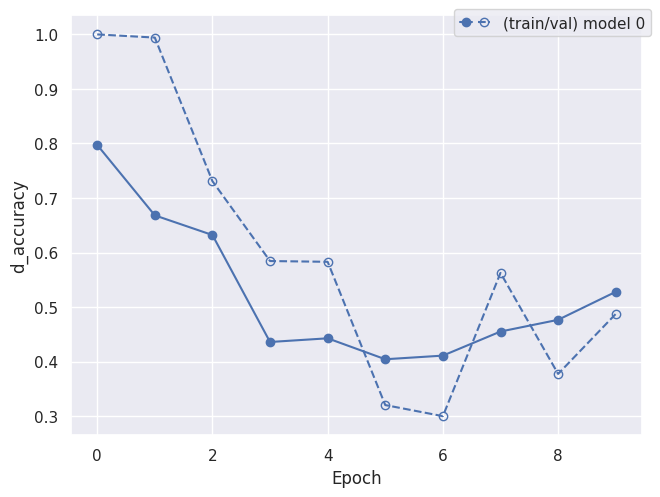

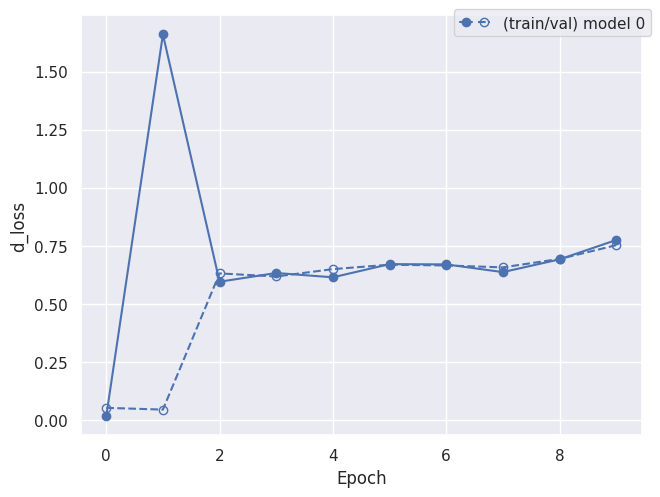

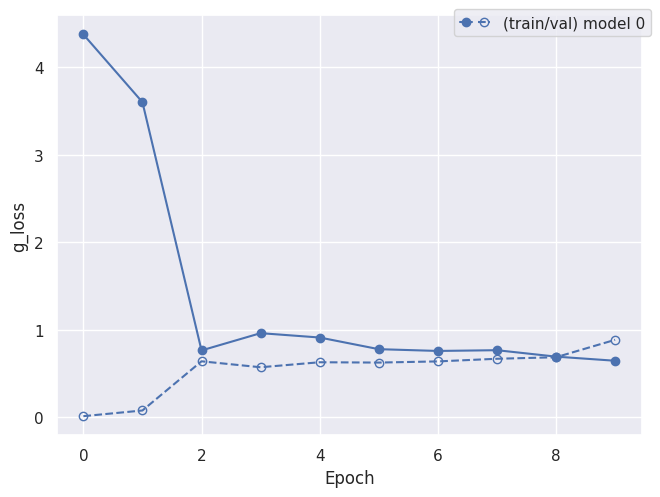

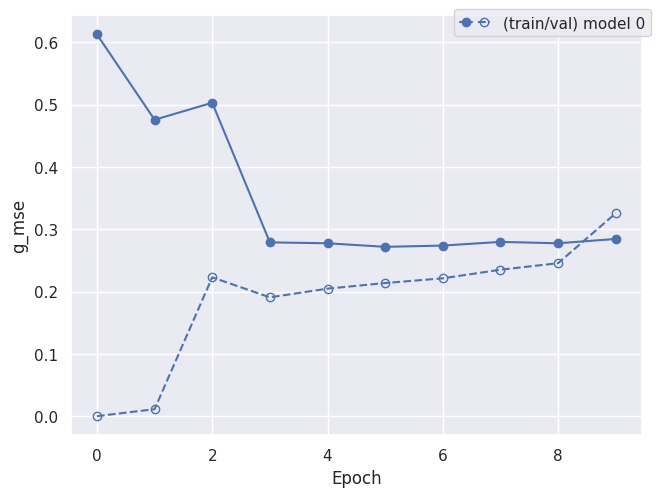

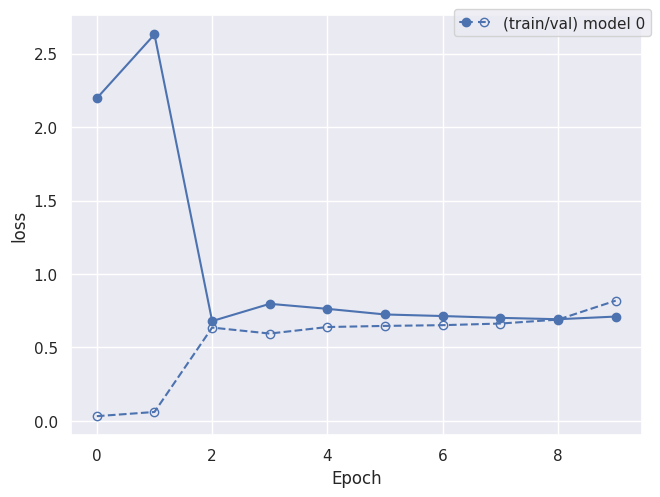

In [170]:
plot_hypertune_histories(histories)

In [140]:
[col for col in histories[0].columns if not col.startswith('val_') and not col.startswith('test_')]

['loss', 'd_loss', 'g_loss', 'd_accuracy', 'g_mse']

In [34]:
acc = keras.metrics.BinaryAccuracy(threshold=0.5)
acc.update_state([[1], [1], [1], [1]], [[0], [0.3], [0.5], [0.7]])
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

In [64]:
tf.size([1,2])

<tf.Tensor: shape=(), dtype=int32, numpy=2>

## Model Building

In [21]:
m_dis = Discriminator(
    model_type='rnn',
    input_shape=(window_len, feat_len),
    n_layers=5,
    hidden_units=256,
    layer_type='gru',
)
m_dis.summary()

latent_shape = (window_len, feat_len*3) # Shape of random vectors used in generation.
m_gen = Generator(
    model_type='rnn',
    input_shape=latent_shape,
    n_layers=5,
    hidden_units=256,
    output_units=feat_len, # Must match number of input features in discriminator.
    layer_type='gru',
)
m_gen.summary()



model = GAN(
    discriminator=m_dis,
    generator=m_gen,
    latent_shape=latent_shape,
)
model.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    d_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False), # Each class has range [0,1], sigmoid was used so no logits.
    g_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False), # Each class has range [0,1], sigmoid was used so no logits.
)

model.fit(
    dataset.take(5),
    epochs=1,
)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU_0 (GRU)                 (None, 24, 256)           199680    
                                                                 
 GRU_1 (GRU)                 (None, 24, 256)           394752    
                                                                 
 GRU_2 (GRU)                 (None, 24, 256)           394752    
                                                                 
 GRU_3 (GRU)                 (None, 24, 256)           394752    
                                                                 
 GRU_4 (GRU)                 (None, 24, 256)           394752    
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 classifier (Dense)          (None, 1)               

## Data Visualization Examples

In [ ]:
def plot(
    n: np.ndarray,
    s: np.ndarray,
    x: np.ndarray,
    fs: float,
    baud: int,
    ):

    plt.figure()

    fig, axd = plt.subplot_mosaic("A;B;C", figsize=(7,12))
    pkey = 'A'
    axd[pkey].plot(n, s, marker='o', markevery=int(fs/baud))
    axd[pkey].set_title('Data')

    pkey = 'B'
    axd[pkey].plot(n, np.real(x), label='real')
    axd[pkey].plot(n, np.imag(x), label='imag')
    axd[pkey].set_title('Signal')
    axd[pkey].legend()

    pkey = 'C'
    axd[pkey].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
    axd[pkey].set_title('Constellation')
    axd[pkey].grid(True)

    return fig

<Figure size 640x480 with 0 Axes>

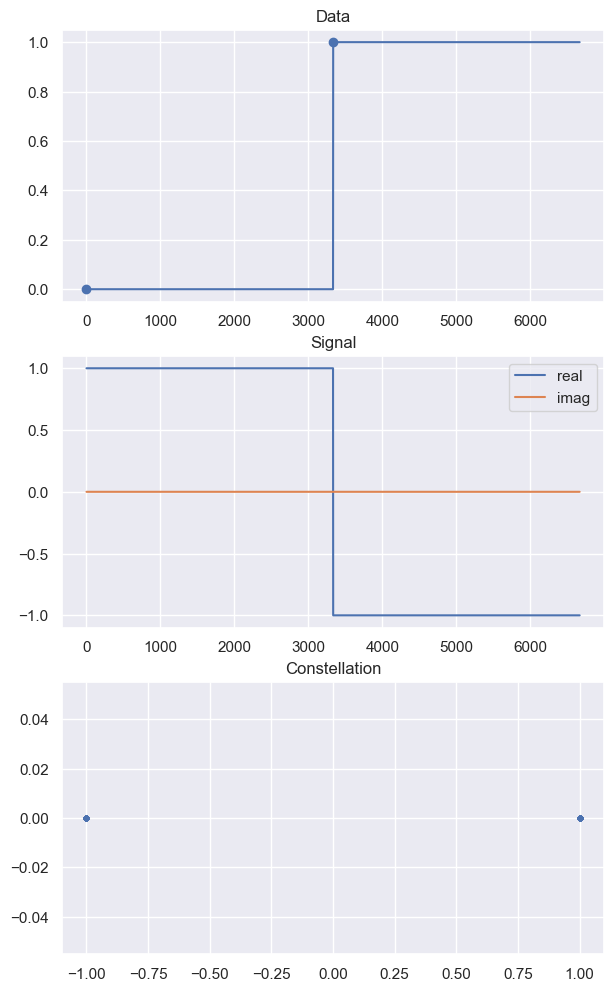

In [ ]:
data, params = load_data(roots['dataset']/"bpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

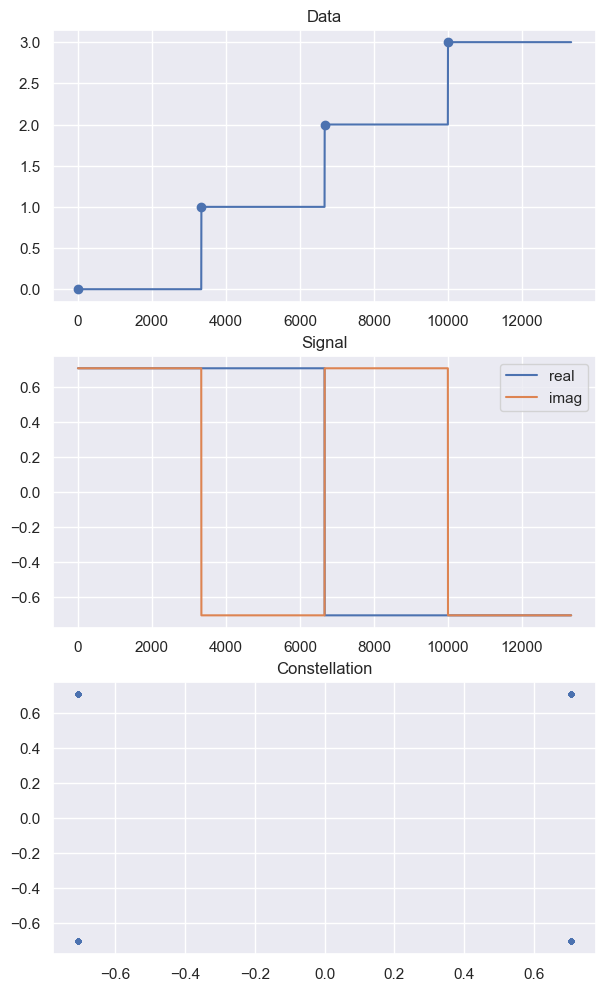

In [ ]:
data, params = load_data(roots['dataset']/"qpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

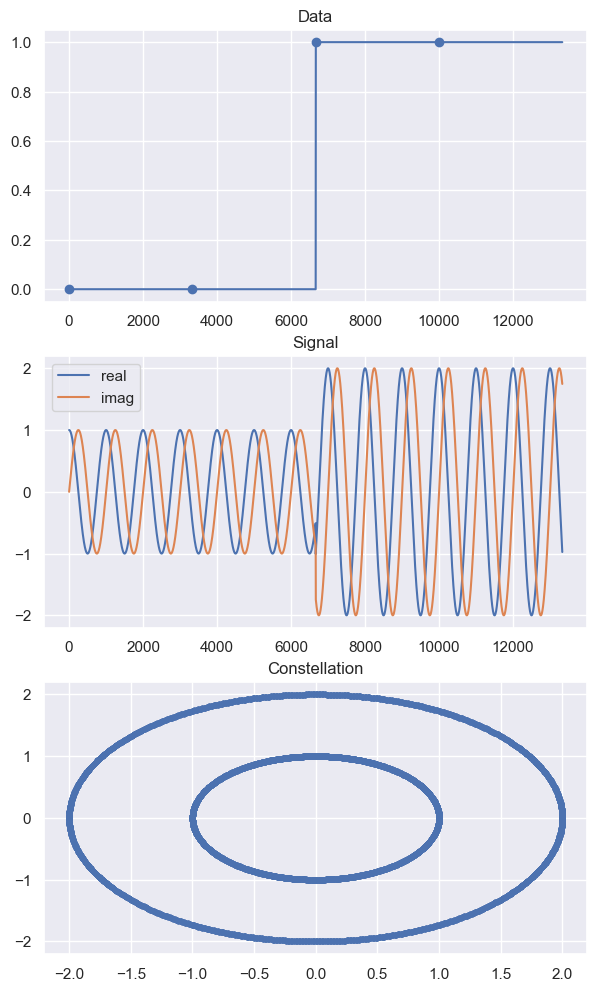

In [ ]:
data, params = load_data(roots['dataset']/"2-ask")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

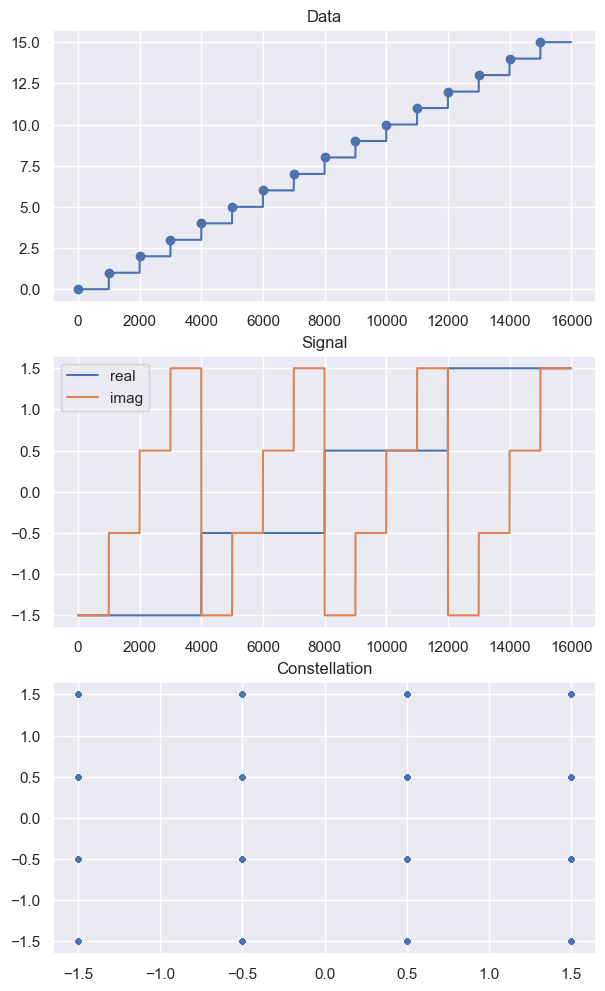

In [ ]:
data, params = load_data(roots['dataset']/"16-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

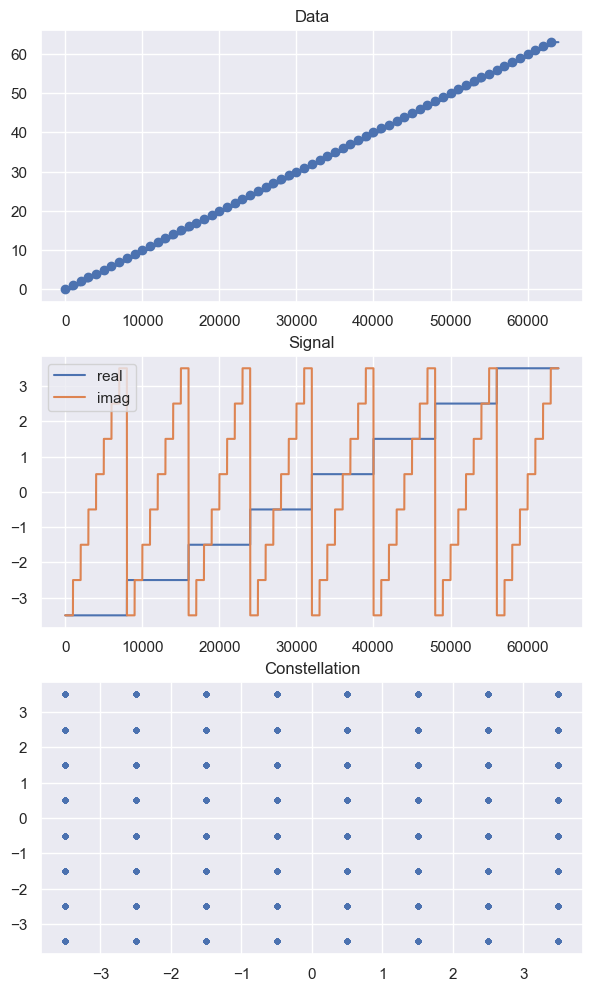

In [ ]:
data, params = load_data(roots['dataset']/"64-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

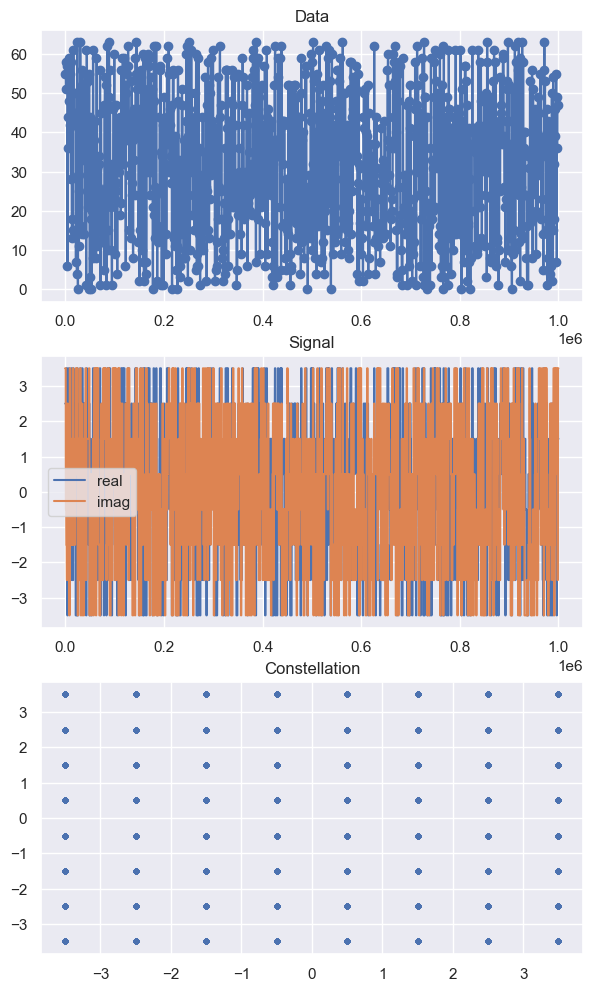

In [ ]:
data, params = load_data(roots['dataset']/"64-qam-long")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)